+ title: Natural Language Processing of German texts - Part 3: Introducing transformer models to predict ratings
+ date: 2020-07-06
+ tags: python, NLP, classification, BERT, neural-networks, tensorflow, transformers
+ Slug: binary-text-classification-predict-ratings-part3-transformer-neural-network-bert
+ Category: Python
+ Authors: MC
+ Summary: Using a unique German data set containing ratings and comments on doctors, we build a Binary Text Classifier. In this third part, we introduce a state of the art model based on the transformer architecture, namely BERT. Using the transformers library for tensorflow, we push our ability to predict the sentiment of comments towards its limit.

In [10]:
# Needed on Google Colab
import os
if os.environ.get('COLAB_GPU', False):
    !pip install -U transformers
    from google.colab import drive
    drive.mount("/content/drive")

     |████████████████████████████████| 2.0MB 6.5MB/s 
     |████████████████████████████████| 870kB 22.7MB/s 
     |████████████████████████████████| 3.3MB 38.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=2b45d9bd956e7a707827d2d77350634b949a777ee2ef5755e132f5d5881be069
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
Mounted at /content/drive


In [1]:
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.4.1


Executing this on Colab will make sure that our model runs on a TPU if available and falls back to GPU / CPU otherwise:

In [2]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.26.88.242:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.26.88.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.26.88.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In our case, we are running on a TPU with eight cores. This will give us an immense speed up!  
As before, we first download and extract our data:

In [3]:
# store current path and download and extract data there
CURR_PATH = !pwd

In [4]:
# PARAMETERS
PATH_DATA = CURR_PATH[0]
PATH_GDRIVE_TMP = "/content/drive/MyDrive/tmp/"  # Google Drive

Let's load the data set and create our target variable. Positive ratings (one or two) will be considered as good and negative ones (five or six) as negative. As before, we ignore neutral ratings:

In [5]:
label_int_map = {'Etat': 0, 'Inland': 1, 'International': 2, 'Kultur': 3, 'Panorama': 4, 'Sport': 5, 'Web': 6, 'Wirtschaft': 7, 'Wissenschaft': 8}
int_label_map = {0: 'Etat', 1: 'Inland', 2: 'International', 3: 'Kultur', 4: 'Panorama', 5: 'Sport', 6: 'Web', 7: 'Wirtschaft', 8: 'Wissenschaft'}

In [6]:
# read data from csv
data = pd.read_csv(PATH_GDRIVE_TMP + "10kGNAD_all.csv", sep=';', header=None, quotechar="'")

# Create binary grade, class 1-2 or 5-6  = good or bad
data["opinion_integer"] = 0
data['opinion_integer'] = data[0].apply(lambda label: label_int_map[label])
# data.loc[data[6] == 'o', "opinion_integer"] = 1
# data.loc[data[6] == '+', "opinion_integer"] = 2

data.tail(1)

FileNotFoundError: ignored

Our cleaning and pre-processing strategy will be almost identical to the [second post]({filename}/doctors_nlp2.ipynb). We will keep the text structure unchanged and only tidy it up a bit. The only difference to before is that we won't transform the texts to lowercase:


In [7]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Now, we can we apply this pre-processing and cleaning to our original data:

In [ ]:
%%time
# Clean Comments
data["comment_clean"] = data.loc[data[1].str.len() > 20, 1]
data["comment_clean"] = data["comment_clean"].map(
    lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x
)

CPU times: user 37.3 s, sys: 100 ms, total: 37.4 s
Wall time: 37.3 s


In [ ]:
data['totalwords'] = data['comment_clean'].str.count(' ') + 1

In [ ]:
data['totalwords'].max()

5234

This is how the final comments will look like:

In [ ]:
data

text  label
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
# Drop Missing
data = data.dropna(axis="index", subset=["opinion_integer", "comment_clean"]).reset_index(
    drop=True
)
data = data[["comment_clean", "opinion_integer"]]
data.columns = ["text", "label"]
data.head(2)
data.to_csv(PATH_GDRIVE_TMP + "10kGNAD_all_pp.csv", index=False)

In [11]:
# skip pre processing if done before
data = pd.read_csv(PATH_GDRIVE_TMP + "10kGNAD_all_pp.csv")

In [12]:
# this will download and initialize the pre trained tokenizer
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

The inputs expected by BERT are very similar to the ones we've used before: they are just vectors containing integers which can be mapped to tokens by using a dictionary. The only difference is that BERT expects several "special" tokens. `[CLS]` stands for classification and marks the beginning of a new input to be classified. `[SEP]` marks the separation between sentences. Finally, `[PAD]` is used as a placeholder in order to pad all vectors to the same fixed length. The helper method `encode_plus` of the `Tokenizer` object deals with creating the numeric vectors while taking care of the extra tokens: 



In [13]:
#MAXLEN = 5120
MAXLEN = 512

def preprocess_text(data):
    """ take texts and prepare as input features for BERT 
    """
    input_ids = []
    # For every sentence...
    for comment in data:
        encoded_sent = tokenizer.encode_plus(
            text=comment,
            add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
            max_length=MAXLEN,  # Max length to truncate/pad
            pad_to_max_length=True,  # Pad sentence to max length
            return_attention_mask=False,  # attention mask not needed for our task
        )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get("input_ids"))
    return input_ids

Before creating our features, let's check out the workings of the tokenizer with an example:

In [14]:
# Original Comment and encoding outputs
comment = ["Klimatische Verschlechterungen dürften zur Aufgabe der Siedlung geführt haben ein Prozess , der Menschen in der Sahelzone auch heute noch betrifft . "]
input_ids = preprocess_text(comment)
print("Comment: ", comment)
print("Tokenized Comment: ", tokenizer.convert_ids_to_tokens(input_ids[0])[0:20])
print("Token IDs: ", input_ids[0][0:20])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Comment:  ['Klimatische Verschlechterungen dürften zur Aufgabe der Siedlung geführt haben ein Prozess , der Menschen in der Sahelzone auch heute noch betrifft . ']
Tokenized Comment:  ['[CLS]', 'Klima', '##ti', '##sche', 'Verschlechter', '##ungen', 'dürften', 'zur', 'Aufgabe', 'der', 'Siedlung', 'geführt', 'haben', 'ein', 'Prozess', ',', 'der', 'Menschen', 'in', 'der']
Token IDs:  [3, 6914, 15099, 1065, 26712, 184, 9191, 252, 4177, 21, 7655, 3818, 474, 39, 2882, 26918, 21, 1075, 50, 21]


First, you can see the special tokens being automatically added in the right places. Second, we see that some tokens simply correspond to regular words, i.e. "Ich" and "liebe". This will be the case for all words that are in the vocabulary. Here, that will amount to most regular German words. In contrast, unknown words get a special treatment. Instead of just being left out, as was the case with the FastText embeddings, they are split to shorter character sequences. For example "data", which is not a German word, becomes "dat" and "##a". This allows the model to still use these novel words.  
There is one more major difference between BERT's word embeddings and e.g. FastText's. Recall how vector representations of words with similar semantic meaning in FastText were similar, i.e. had a short distance between them. This allowed our model to group similar words together. BERT takes this one step further. A word's vector representation is not static anymore but depends on context. Consequently, the vector for "broke" is different when it's in a context of "money" vs. " a record". This immensely improves contextual awareness and might benefit predictions in many cases.  
Now, we apply the tokenization process to our data:

In [29]:
data.head(2)

,text,label
0,"Die ARD Tochter Degeto hat sich verpflichtet , ab August einer Quotenregelung zu folgen , die für die Gleichstellung von Regisseurinnen sorgen soll . In mindestens Prozent der Filme , die die ARD Tochter Degeto produziert oder mitfinanziert , sollen ab Mitte August Frauen Regie führen . Degeto Chefin Christine Strobl folgt mit dieser Selbstverpflichtung der Forderung von Pro Quote Regie . Die Vereinigung von Regisseurinnen hatte im vergangenen Jahr eine Quotenregelung gefordert , um den weiblichen Filmschaffenden mehr Gehör und ökonomische Gleichstellung zu verschaffen . Pro Quote Regie kritisiert , dass , während rund Prozent der Regie Studierenden weiblich seien , der Anteil der Regisseurinnen bei Fernsehfilmen nur bei bis Prozent liege . In Österreich sieht die Situation ähnlich aus , auch hier wird von unterschiedlichen Seiten Handlungsbedarf angemahnt . Aber wie soll dieser aussehen ? Ist die Einführung der Quotenregelung auch für die österreichische Film und Fernsehlandschaft sinnvoll ? Diskutieren Sie im Forum .",0
1,"App sei nicht so angenommen worden wie geplant . Wegen zu geringer Nutzung schaltet Spiegel Online nach zwei Jahren die Fußball App aus , die App sei nicht so genutzt worden , wie man sich das vorgestellt habe . Dafür soll der Live Fußball Bereich in der News App ausgebaut werden .",0


In [15]:
%%time
import pickle

input_ids = preprocess_text(data["text"])
# tokenization takes quite long
# we can save the result and load it quickly via pickle
pickle.dump(input_ids, open(PATH_GDRIVE_TMP + "input_ids_10kGNAD_all.pkl", "wb"))
# input_ids = pickle.load(open(PATH_GDRIVE_TMP+"/input_ids.pkl", "rb"))

CPU times: user 1min 33s, sys: 169 ms, total: 1min 33s
Wall time: 1min 34s


Next, we split out data into train and test for cross validation:

In [16]:
# Sample data for cross validation
train_ids, test_ids, train_labels, test_labels = train_test_split(
    input_ids, data["label"], random_state=1, test_size=0.10, shuffle=True
)
print(f"Train set: {len(train_ids)}\nTest set: {len(test_ids)}")

Train set: 9245
Test set: 1028


Here, we set the model parameters. `MAXLEN` is the max. number of tokens in our input. Longer inputs will be truncated to this. While greater lengths will yield better predictions, they also mean a greater computational toll. We differentiate between `BATCH_SIZE_PER_REPLICA` and `BATCH_SIZE` when we run on multiple GPUs or TPUs, as is the case on Google Colab. Each TPU core will deal with `BATCH_SIZE_PER_REPLICA` batches at a time. `EPOCHS` is simply the number of training iterations over the whole training set:

In [17]:
strategy.num_replicas_in_sync

8

In [18]:
# Set Model Parameters
MAXLEN = MAXLEN
BATCH_SIZE_PER_REPLICA = 8
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCHS = 8
LEARNING_RATE = 1e-5
DATA_LENGTH = len(data)

As a last step before building our model, we need to prepare our dataset. Before, we used NumPy arrays as inputs. Here, we use the `tf.data.Dataset` class which offers several convenient methods:

In [19]:
def create_dataset(
    data_tuple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    buffer_size=DATA_LENGTH,
    train=False,
):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(
            buffer_size=buffer_size, reshuffle_each_iteration=True
        ).repeat(epochs)
    dataset = dataset.batch(batch_size)
    return dataset


train = create_dataset(
    (train_ids, train_labels), buffer_size=len(train_ids), train=True
)
test = create_dataset((test_ids, test_labels), buffer_size=len(test_ids))

Finally, we define a function that returns our model architecture:

In [20]:
def build_model(transformer, max_len=MAXLEN):
    """ add binary classification to pretrained model
    """
    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = tf.keras.layers.Dense(9, activation="sigmoid")(cls_token)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=out)
    model.compile(
        tf.keras.optimizers.Adam(lr=LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In the first step, we define an `Input` layer which expects our numeric vectors as input. Then, we add the pre trained transformer which receives the inputs from the previous layer. The output of the transformer is then fed into a `Dense` layer which finally outputs a probability for our input belonging to class 0 or 1.  
Now, we build our model by first downloading the pre trained BERT and passing it to our `build_model` function:

In [21]:
with strategy.scope():
    transformer_layers = TFBertModel.from_pretrained("bert-base-german-cased")
    model = build_model(transformer_layers, max_len=MAXLEN)
model.summary()

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109081344 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 9)                 6921      
Total params: 109,088,265
Trainable params: 109,088,265
Non-trainable params: 0
_________________________________________________________________


In total we have almost 110 Mio. trainable parameters. It's convenient that almost all of them have already been trained. Because we use the pre trained weights for them, they will only need to change ever so slightly. Still, it is a big model and even training on GPUs takes considerable time. So again, good thing that we can use TPUs.  
Next, we define callbacks that will be used during training. The `EartlyStopping` callback will stop the training if validation loss stops decreasing between epochs. This avoids overfitting. `ModelCheckpoint` saves checkpoints of the model after each epoch, so that training can be resumed. On Google Colab, you can currently only save TPU models in a Cloud Bucket but not on a mounted Google Drive. Hence, I commented out that part:

In [22]:
# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=1, restore_best_weights=True
    ),
    # tf.keras.callbacks.ModelCheckpoint(
    #    PATH_GDRIVE_TMP + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
    #    monitor="val_loss",
    #    save_best_only=True,
    #    verbose=1,
    # ),
]

Finally, time to get excited! We can now start the model training:

In [23]:
%%time
# Train using appropriate steps per epochs (go through all train data in an epoch)
steps_per_epoch = int(np.floor((len(train_ids) / BATCH_SIZE)))
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Learning rate: {LEARNING_RATE}"
)
hist = model.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=test,
    verbose=1,
    callbacks=callbacks,
)

Model Params:
batch_size: 64
Epochs: 8
Step p. Epoch: 144
Learning rate: 1e-05
Epoch 1/8


144/144 [==============================] - ETA: 0s - loss: 1.5118 - accuracy: 0.4675WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


144/144 [==============================] - 124s 346ms/step - loss: 1.5077 - accuracy: 0.4690 - val_loss: 0.4291 - val_accuracy: 0.8531
Epoch 2/8
144/144 [==============================] - 36s 247ms/step - loss: 0.3391 - accuracy: 0.8824 - val_loss: 0.3584 - val_accuracy: 0.8833
Epoch 3/8
144/144 [==============================] - 36s 250ms/step - loss: 0.2460 - accuracy: 0.9163 - val_loss: 0.3486 - val_accuracy: 0.8852
Epoch 4/8
144/144 [==============================] - 36s 247ms/step - loss: 0.1558 - accuracy: 0.9528 - val_loss: 0.3553 - val_accuracy: 0.8920
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
CPU times: user 47 s, sys: 5.54 s, total: 52.5 s
Wall time: 4min 25s


The model converges really fast and stops early after only three epochs. This is because it already achieves the lowest validation loss in the second period:

[Text(0, 0.5, ''),
 [Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3'), Text(0, 0, '4')],
 Text(0.5, 1.0, 'Model loss')]

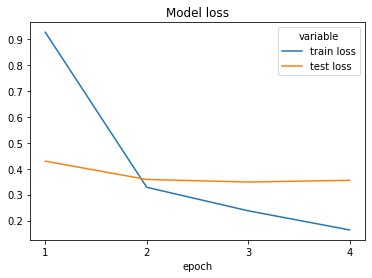

In [24]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
)

Since the low loss value indicates that our model is already really good, we don't do any hyperparameter tuning. Also, our parameters were already chosen with good care. However, when looking for peak performance, it would be reasonable to compare different configurations. Natural starting points would be to:
1. Increasing the input length
2. Change the learning rate or use a dynamic rate adaption
3. Try different batch sizes

I'd expect to see some further but very marginal improvement from these steps.

### Evaluation 

Was this all worth it? Let's find out:

In [25]:
# predict on test set
pred = model.predict(test, batch_size=BATCH_SIZE, verbose=2, use_multiprocessing=True)

17/17 - 15s


In [26]:
np.argmax(pred, axis=-1)

array([2, 5, 3, ..., 7, 0, 4])

In [27]:
# Load best model from Checkpoint
# model = load_model(PATH_GDRIVE_TMP+"BERT.h5", compile=False)
pred_class = np.argmax(pred, axis=-1)
report = metrics.classification_report(test_labels, pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        74
           1       0.87      0.78      0.82       119
           2       0.91      0.90      0.91       145
           3       0.84      0.88      0.86        48
           4       0.86      0.83      0.84       178
           5       0.97      0.97      0.97       118
           6       0.91      0.93      0.92       161
           7       0.80      0.94      0.86       136
           8       0.94      0.90      0.92        49

    accuracy                           0.89      1028
   macro avg       0.89      0.88      0.88      1028
weighted avg       0.89      0.89      0.88      1028



Let's recap our previous results: In [the first part]({filename}/doctors_nlp1.ipynb) we used a traditional classification method and achieved a decent macro f1-score of `0.9`. In [part two]({filename}/doctors_nlp1.ipynb), we improved the score to `0.93` using a LSTM neural network and FastText word embeddings. For our harder to predict class 1 (bad ratings), we had a precision of `0.86` and recall of `0.89`.  
Compared to that, our BERT approach is a significant improvement. We increase the macro f1 to `0.94` while getting a decent improvement in both, the precision and recall for class 1 . You might be fooled by the small increase of the absolute numbers and wonder why I'm talking about "big improvement". Well, we really need to put this into relation. The better a model already performs, the harder it gets to squeeze out further improvements. An increase from a f1 of `0.6` to `0.7` is usually easier to achieve and less impressive than an improvement from `0.95` to `0.97`. Think "pareto principle" and "decreasing marginal returns"! 


### Conclusion

In this third part of our series, we have further advanced our binary text classification model of German comments of patients on their doctors. We have introduced the transformer architecture and more specifically the BERT model. Using the HuggingFace `transformers` library for Python, we have fine tuned a pre trained German language BERT model. For that training, we have used a free Google Colab instance with a TPU. As a final result, we have significantly improved the capacity of our prediction model once more. The classifier is able to assign the correct sentiment to comments and predict their ratings with high proficiency.  
This concludes our search for the best possible classification model for our task. However, our NLP journey is not finished yet: In the next part of this series, we will use this data set to explore the capability of AIs to generate text. Using the GPT-2 neural network architecture, we will build a model that generates comments in German. Will our approach be able to create credible patient reviews in a medical context?
<br>